In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
%load_ext autoreload
%autoreload 2
import weather_alphas, weather_costs, model, model_01, validate, prediction

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


running model
getting cost from nweek ahead
getting bounded alphas ...
done getting alphas ...
running model


In [2]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask]
    test_mask = (data.index > "2011")
    test = data[test_mask]
    return train, test

def remove_space(province):
    if type(province) == str:
        return province.replace(" ", "")



In [3]:
all_weather = pd.read_csv("weather01-16.csv")
all_weather.stn_name = all_weather.stn_name.apply(remove_space)

all_dengue = pd.read_csv("all-dengues.csv")

In [11]:
print all_weather.stn_name.unique()
print all_dengue['จังหวัด'].unique()

['ChiangRai' 'ChiangMai' 'KamphaengPhet' 'ThaPhraAgromet' 'Kamalasai'
 'ChaiNat' 'Chaiyaphum' 'ChacherngsaoAgromet' 'Kanchanaburi'
 'BangkokMetropolis' 'ChonBuri' 'PhriuAgromet' 'SawiAgromet' 'Krabi' 'Nan'
 'NakhonPhanom' 'Tak' 'NakhonSawan' 'PathumthaniAgromet' 'NakhonRatchasima'
 'Burirum' 'KamphaengSaenAgromet' 'PrachuapKhiriKhan' 'KhlongYai'
 'NakhonSiThammarat' 'TrangAirport' 'Narathiwat' 'Phayao' 'Phrae'
 'Phitsanulok' 'Phetchabun' 'Mukdahan' 'PichitAgromet' 'KosumPhisai'
 'AyuttayaAgromet' 'PrachinBuri' 'Phetchaburi' 'PhatthalungAgromet'
 'TakuaPa' 'Phuket' 'PattaniAirport' 'MaeHongSon' 'Lampang' 'Lamphun'
 'LoeiAgromet' 'SakonNakhonAgromet' 'RoiEt' 'SiSaKetAgromet' 'Ratchaburi'
 'LopBuri' 'Rayong' 'Ranong' 'KhoHongAgromet' 'YalaAgromet' 'Uttaradit'
 'NongKhai' 'UdonThani' 'Sukhothai' 'SiSamrongAgromet'
 'UbonRatchathaniAgromet' 'UThongAgromet' 'PilotStation'
 'SuwanabhumAirport' 'SurinAgromet' 'SaKaew' 'SuratThaniAgromet' 'Satun'
 None]
['Nan' 'SuratThani' 'Bangkok' 'Uttaradit'

In [4]:
# cm_weather = all_weather[all_weather.stn_name == "ChiangMai"]
# cm_weather.index = pd.DatetimeIndex(cm_weather.date)
# mask = (cm_weather.index > "2003") & (cm_weather.index < "2016")
# cm_weather = cm_weather[mask]

# all_dengue = pd.read_csv("all-dengues.csv")
# all_dengue.index = pd.DatetimeIndex(all_dengue.date)
# all_dengue = all_dengue.drop(['date','date.1'],axis=1)
# cm_dengues = all_dengue[all_dengue['จังหวัด'] == 'ChiangMai'].resample('W').size()
# cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])

In [5]:
# cm_avg_weather = cm_weather[['avgrh','dday','meantemp']].resample('W').mean()
# cm_avg_weather['rain'] = cm_weather[['rain']].resample('W').sum() # cumulative rainfall
# cm_dengues_weather = pd.concat([cm_avg_weather,cm_dengues_df[:-52]],axis=1)

# cm_dengues_weather_split = split_data(cm_dengues_weather)
# cm_dengues_train, cm_dengues_test = cm_dengues_weather_split[0], cm_dengues_weather_split[1]

In [8]:
all_weather = pd.read_csv("weather01-16.csv")
all_dengue = pd.read_csv("all-dengues.csv")
def get_dengue_weather_by_province(province_for_dengue,
                                   province_for_weather,
                                   all_dengue=all_dengue,
                                   all_weather=all_weather):
    
    all_weather.stn_name = all_weather.stn_name.apply(remove_space)
    province_weather = all_weather[all_weather.stn_name == province_for_weather]
    province_weather.index = pd.DatetimeIndex(province_weather.date)
    mask = (province_weather.index > "2003") & (province_weather.index < "2016")
    province_weather = province_weather[mask]
    
    all_dengue.index = pd.DatetimeIndex(all_dengue.date)
    all_dengue = all_dengue.drop(['date','date.1'],axis=1)
    province_dengues = all_dengue[all_dengue['จังหวัด'] == province_for_dengue].resample('W').size()
    province_dengues_df = pd.DataFrame(province_dengues,columns=['cases'])
    
    province_avg_weather = province_weather[['avgrh','dday','meantemp']].resample('W').mean()
    province_avg_weather['rain'] = province_weather[['rain']].resample('W').sum() # cumulative rainfall
    province_dengues_weather = pd.concat([province_avg_weather,province_dengues_df[:-52]],axis=1)
    province_dengues_weather = province_dengues_weather.fillna(0)

    province_dengues_weather_split = split_data(province_dengues_weather)
    province_dengues_train, province_dengues_test = province_dengues_weather_split[0], province_dengues_weather_split[1]
    
    return province_dengues_train, province_dengues_test, province_dengues_weather

In [9]:
                       # province_dengue: province_weather
                       # add in "Songkhla":""PhatthalungAgromet"
provinces_to_predict = {"Bangkok":"BangkokMetropolis", 
                        "Nonthaburi":"BangkokMetropolis",
                        "PhraNakhonSiAyutthaya":"AyuttayaAgromet", 
                        "Phuket":"Phuket", 
                        "Ratchaburi":"Ratchaburi", 
                        "ChonBuri":"ChonBuri", 
                        "NongKhai":"NongKhai",
                        "SakonNakhon":"SakonNakhonAgromet",
                        "ChiangMai":"ChiangMai",
                        "ChiangRai":"ChiangRai"}

for province_for_dengue in provinces_to_predict:
    province_for_weather = provinces_to_predict.get(province_for_dengue)
    print province_for_dengue, province_for_weather
#     get_dengue_weather_by_province(province_for_dengue, province_for_weather)

Bangkok BangkokMetropolis
[                avgrh       dday   meantemp   rain  cases
date                                                     
2003-01-05  64.000000   3.500000  28.750000    0.0    224
2003-01-12  64.714286   9.000000  27.228571    0.0    274
2003-01-19  70.285714  16.000000  26.457143    0.0    183
2003-01-26  70.285714  23.000000  28.100000    0.0    194
2003-02-02  65.000000  21.142857  28.942857    0.0    181
2003-02-09  60.000000   6.000000  27.742857    0.0    162
2003-02-16  75.571429  13.000000  29.914286    0.4    147
2003-02-23  74.857143  20.000000  30.214286    0.0    161
2003-03-02  74.428571  19.000000  30.585714    0.3    178
2003-03-09  73.428571   6.000000  30.757143   17.2    149
2003-03-16  72.142857  13.000000  28.900000   28.4    136
2003-03-23  75.285714  20.000000  30.271429   50.4    102
2003-03-30  77.571429  27.000000  29.100000   38.6     95
2003-04-06  69.857143   7.428571  31.100000    0.0    120
2003-04-13  72.571429  10.000000  31.585714  

In [32]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(real)),real,'-r',label=real_legend)
    plt.plot(range(start_week,len(predictions)+start_week),predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)
    
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,700,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,700,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)
    
def plot_all_predictions(LAG, real, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real,label='real')
    graph_title = "%s's Dengue Prediction with Mean Temperature"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    seperate_train_test(cm_dengues_df.cases,cm_dengues_train)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend()
    plt.savefig("16-lags-16-weeks-9-temp-wks-chiangmai-00.png")
    
def show_predictions(params, real, province, ws):
    LAG, TEMPERATURE_WEEKS, RAIN_WEEKS = params[0], params[1], params[2]
    predictions_to_plot = prediction.get_predictions(LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, real, ws, "CM")
    plot_all_predictions(LAG, real.cases, province, [1,2,4,8,16], predictions_to_plot)

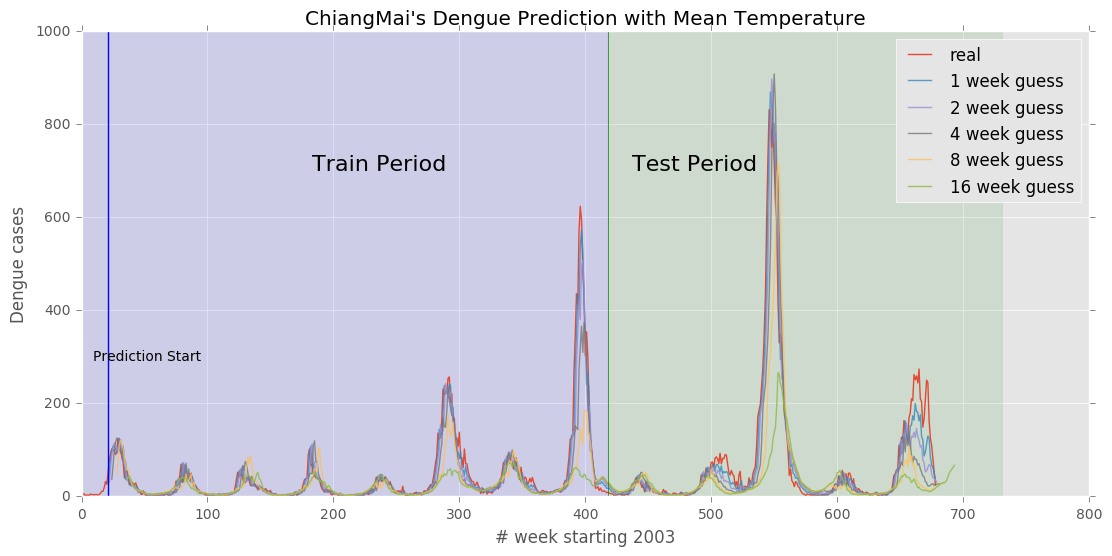

In [33]:
ws = np.array(pd.read_csv("best-for-21-lags-ws.csv").T)[0]
LAG, TEMPERATURE_WEEKS, RAIN_WEEKS = 21, 9, 10
real = cm_dengues_weather

show_predictions([21,9,10], real, "ChiangMai", ws)

# predictions_to_plot = prediction.get_predictions(LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, real, ws, "CM")
# plot_all_predictions(LAG, real.cases, "ChiangMai", [1,2,4,8,16], predictions_to_plot)

In [26]:
cm_dengues_weather

,avgrh,dday,meantemp,rain,cases
date,,,,,
2003-01-05,88.250000,3.500000,23.500000,12.2,1
2003-01-12,81.000000,9.000000,22.828571,0.0,2
2003-01-19,80.714286,16.000000,21.457143,0.0,5
2003-01-26,75.857143,23.000000,20.671429,0.0,0
2003-02-02,75.857143,21.142857,22.628571,0.0,2
2003-02-09,74.857143,6.000000,22.728571,0.0,2
2003-02-16,70.857143,13.000000,24.957143,0.0,1
2003-02-23,62.857143,20.000000,24.200000,0.0,4
2003-03-02,57.857143,19.000000,24.457143,0.0,3
